# Data Augmentation Effect on Fine-Tuning VGG16 and ResNet50 for Image Classification

In this notebook, we will show the effect of data augmentation on fine-tuning VGG16 and ResNet50 for image classification. I will use a sample dataset of cats and dogs images. The dataset is available at [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data). 

## Introduction

Fine-tuning is a transfer learning technique that allows us to use a pre-trained model as a starting point for a new task. The idea is to leverage the knowledge learned by the pre-trained model on a new dataset. This is particularly useful when we have a small dataset. Data augmentation is a technique used to artificially increase the size of the training dataset by applying random transformations to the original images. This helps to improve the generalization of the model. We will show the effect of data augmentation on fine-tuning VGG16 and ResNet50 for image classification.

In [1]:
import os
import cv2
import numpy as np
from tensorflow import keras
import tensorflow as tf

np.random.RandomState(7)
def read_images_of(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg'):
            img_path = os.path.join(folder_path, filename)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            image = image / 255.0
            if image is not None:
                images.append(image)
    images = np.array(images)
    return images

cats_train = read_images_of("../data/HW2_Dataset/Train/Cats")
cats_test = read_images_of("../data/HW2_Dataset/Test/Cats")
dogs_train = read_images_of("../data/HW2_Dataset/Train/Dogs")
dogs_test = read_images_of("../data/HW2_Dataset/Test/Dogs")


In [2]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

train_data = np.concatenate((cats_train, dogs_train), axis=0)
cats_label = np.ones(cats_train.shape[0], dtype=int)
dogs_label = np.zeros(dogs_train.shape[0], dtype=int)
train_labels = np.concatenate((cats_label, dogs_label), axis=0).reshape(-1, 1)


shuffle_indices = np.random.permutation(train_data.shape[0])
train_data = train_data[shuffle_indices]
train_labels = train_labels[shuffle_indices]
train_labels = encoder.fit_transform(train_labels)


test_data = np.concatenate((cats_test, dogs_test), axis=0)
cats_label = np.ones(cats_test.shape[0], dtype=int)
dogs_label = np.zeros(dogs_test.shape[0], dtype=int)
test_labels = np.concatenate((cats_label, dogs_label), axis=0).reshape(-1, 1)

shuffle_indices = np.random.permutation(test_data.shape[0])
test_data = test_data[shuffle_indices]
test_labels = test_labels[shuffle_indices]
test_labels = encoder.fit_transform(test_labels)


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_labels, test_size=0.3, random_state=7)

In [4]:
import matplotlib.pyplot as plt

def plot_metrics(history):

    fig, axs = plt.subplots(2, 1, figsize=(8, 8))

    axs[0].plot(history.history['loss'], label='Training Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(history.history['accuracy'], label='Training Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.tight_layout()
    plt.show()


In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    rotation_range = 30,
    zoom_range = (0.75, 1.25)
).flow(
    x = X_train,
    y = y_train,
    batch_size = 10
)


valid_datagen = ImageDataGenerator().flow(
    x = X_valid,
    y = y_valid,
    batch_size = 10
)

In [6]:
def evaluate_test(model):
    with tf.device("/cpu:0"):
        y_pred = model.predict(test_data)
        y_pred = np.argmax(y_pred, axis = 1)
        y_true = np.argmax(test_labels, axis = 1)
        acc = np.mean(y_true == y_pred)
        print(acc)

In [7]:
def save_weights(model, weights_path):
    model.save_weights(weights_path)
    print("Saved model to disk")

def load_weights(model, weights_path:str):
    model.load_weights(weights_path)
    print("Loaded model from disk")

    return model

In [ ]:
# vgg16_model = VGG16(input_shape=(224, 224, 3), include_top = False, weights = 'imagenet')
# vgg16_model.trainable = False
# x = vgg16_model.output
# x = Layers.BatchNormalization(name = 'BatchNormalization')(x)
# x = Layers.GlobalAveragePooling2D()(x)
# x = Layers.Dropout(0.5)(x)
# x = Layers.Dense(256)(x)
# x = Layers.LeakyReLU(alpha=0.1)(x)
# x = Layers.Dropout(0.25)(x)
# outputs = Layers.Dense(2, activation = 'softmax')(x)

# model = Model(inputs = vgg16_model.input, outputs = outputs)
# model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
# model.summary()

# MODELS
---

In [8]:
from keras.applications import VGG16, ResNet50
from keras.models import Sequential
from keras import layers as Layers

def scheduler(epoch, lr):
    decay_rate = 0.002
    new_lr = lr / (1.0 + decay_rate * epoch)
    return new_lr

LR_sched = keras.callbacks.LearningRateScheduler(scheduler)    

In [9]:
def create_model_vgg16():

    cnn_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    model = Sequential()
    model.add(cnn_base)
    model.add(Layers.Flatten())
    model.add(Layers.Dense(512, activation='relu'))
    model.add(Layers.Dropout(0.5))
    model.add(Layers.Dense(128, activation='relu'))
    model.add(Layers.Dropout(0.3))
    model.add(Layers.Dense(2, activation='softmax'))
    return cnn_base, model

In [12]:
def create_model_resnet50():
    cnn_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Sequential()
    model.add(cnn_base)
    model.add(Layers.GlobalMaxPooling2D())
    model.add(Layers.BatchNormalization())
    model.add(Layers.Dense(2, activation='softmax'))
    
    return cnn_base, model

In [11]:
# _, model = create_model_vgg16()
# _.trainable = False
# model.summary()


# VGG16 - BASE

---

In [14]:
cnn_base, model = create_model_vgg16()

cnn_base.trainable = False
model.summary(show_trainable=True)

Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  N          
                                                                            
 flatten (Flatten)           (None, 25088)             0         Y          
                                                                            
 dense (Dense)               (None, 512)               12845568  Y          
                                                                            
 dropout (Dropout)           (None, 512)               0         Y          
                                                                            
 dense_1 (Dense)             (None, 128)               65664     Y          
                                                                            
 dropout_1 (Dropout)         (None, 128)               0

Epoch 1/15
50/50 [==============================] - 10s 109ms/step - loss: 0.9019 - accuracy: 0.4949 - val_loss: 0.7320 - val_accuracy: 0.5213 - lr: 2.0000e-05
Epoch 2/15
50/50 [==============================] - 5s 92ms/step - loss: 0.7948 - accuracy: 0.5377 - val_loss: 0.6289 - val_accuracy: 0.6398 - lr: 1.9960e-05
Epoch 3/15
50/50 [==============================] - 5s 95ms/step - loss: 0.7201 - accuracy: 0.5642 - val_loss: 0.6067 - val_accuracy: 0.7204 - lr: 1.9881e-05
Epoch 4/15
50/50 [==============================] - 5s 93ms/step - loss: 0.6312 - accuracy: 0.6721 - val_loss: 0.5898 - val_accuracy: 0.7109 - lr: 1.9762e-05
Epoch 5/15
50/50 [==============================] - 5s 93ms/step - loss: 0.6204 - accuracy: 0.6436 - val_loss: 0.5752 - val_accuracy: 0.7536 - lr: 1.9605e-05
Epoch 6/15
50/50 [==============================] - 5s 93ms/step - loss: 0.6157 - accuracy: 0.6538 - val_loss: 0.5564 - val_accuracy: 0.7488 - lr: 1.9411e-05
Epoch 7/15
50/50 [==============================] 

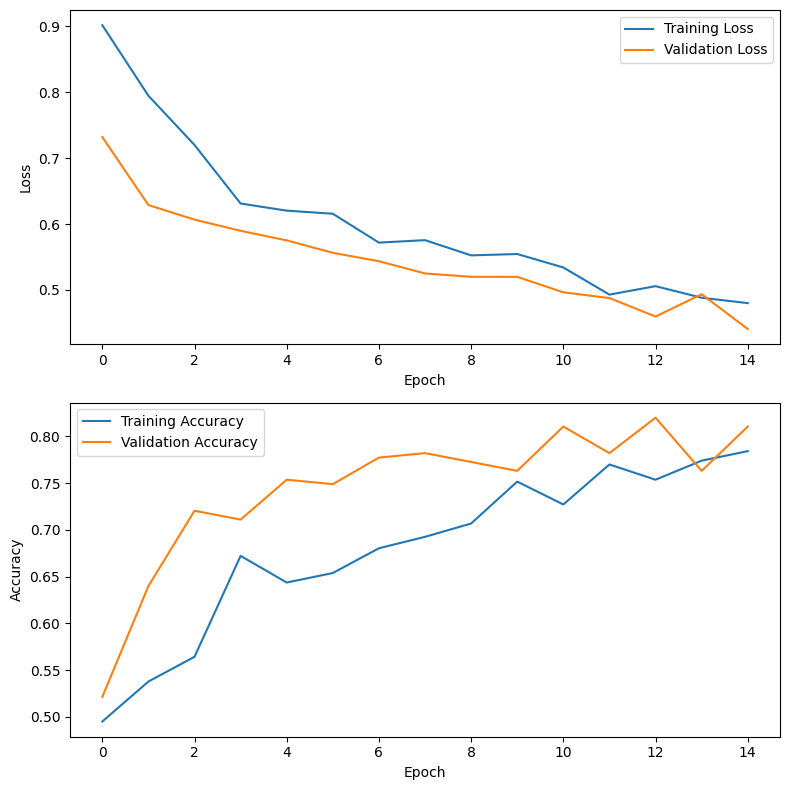

4/4 [==============================] - 8s 2s/step
0.77


In [15]:
import tensorflow as tf

optimizer = keras.optimizers.SGD(learning_rate=2e-5, momentum=0.9)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

with tf.device("/gpu:0"):
    history = model.fit(
        x = X_train,
        y = y_train,
        epochs = 15,
        batch_size = 10,
        validation_data = valid_datagen,
        callbacks = [LR_sched]
    )
plot_metrics(history)
evaluate_test(model)




In [16]:
save_weights(model, weights_path='base_model_vgg16.h5')

Saved model to disk


# VGG16 - NO AUG
---

In [11]:
cnn_base, model = create_model_vgg16()
load_weights(model, weights_path='base_model_vgg16.h5')

Loaded model from disk


In [12]:
cnn_base.trainable = True

set_trainable = False
for layer in cnn_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 2

Epoch 1/50
50/50 [==============================] - 11s 116ms/step - loss: 0.4772 - accuracy: 0.7739 - val_loss: 0.3651 - val_accuracy: 0.8863 - lr: 2.0000e-05
Epoch 2/50
50/50 [==============================] - 5s 98ms/step - loss: 0.4444 - accuracy: 0.8086 - val_loss: 0.3625 - val_accuracy: 0.8626 - lr: 1.9960e-05
Epoch 3/50
50/50 [==============================] - 5s 101ms/step - loss: 0.4228 - accuracy: 0.8147 - val_loss: 0.3375 - val_accuracy: 0.8863 - lr: 1.9881e-05
Epoch 4/50
50/50 [==============================] - 5s 101ms/step - loss: 0.3784 - accuracy: 0.8513 - val_loss: 0.3331 - val_accuracy: 0.8863 - lr: 1.9762e-05
Epoch 5/50
50/50 [==============================] - 5s 105ms/step - loss: 0.4144 - accuracy: 0.8086 - val_loss: 0.3015 - val_accuracy: 0.9052 - lr: 1.9605e-05
Epoch 6/50
50/50 [==============================] - 5s 106ms/step - loss: 0.3816 - accuracy: 0.8391 - val_loss: 0.2952 - val_accuracy: 0.9005 - lr: 1.9411e-05
Epoch 7/50
50/50 [============================

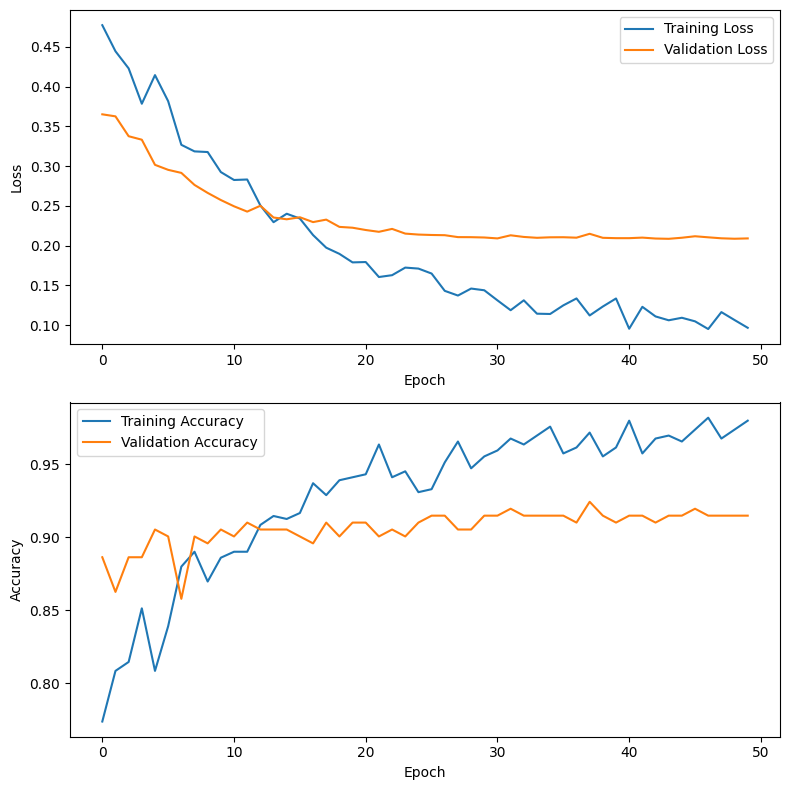

4/4 [==============================] - 9s 2s/step
0.9


In [13]:
optimizer = keras.optimizers.SGD(learning_rate=2e-5, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

with tf.device("/gpu:0"):
    history = model.fit(
        x = X_train,
        y = y_train,
        epochs = 50,
        batch_size = 10,
        validation_data = valid_datagen,
        callbacks = [LR_sched]
    )
plot_metrics(history)

evaluate_test(model)

# VGG16 - AUG

---

In [11]:
cnn_base, model = create_model_vgg16()
model = load_weights(model, weights_path='base_model_vgg16.h5')
evaluate_test(model)

Loaded model from disk
4/4 [==============================] - 8s 2s/step
0.77


In [12]:
cnn_base.trainable = True

set_trainable = False
for layer in cnn_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 2

Epoch 1/50
50/50 [==============================] - 12s 116ms/step - loss: 0.6179 - accuracy: 0.6578 - val_loss: 0.4168 - val_accuracy: 0.8863 - lr: 1.0000e-04
Epoch 2/50
50/50 [==============================] - 5s 100ms/step - loss: 0.6126 - accuracy: 0.6741 - val_loss: 0.6833 - val_accuracy: 0.5924 - lr: 9.9800e-05
Epoch 3/50
50/50 [==============================] - 5s 103ms/step - loss: 0.5545 - accuracy: 0.7189 - val_loss: 0.3311 - val_accuracy: 0.8863 - lr: 9.9403e-05
Epoch 4/50
50/50 [==============================] - 5s 103ms/step - loss: 0.5098 - accuracy: 0.7536 - val_loss: 0.3352 - val_accuracy: 0.8863 - lr: 9.8810e-05
Epoch 5/50
50/50 [==============================] - 5s 102ms/step - loss: 0.4478 - accuracy: 0.7862 - val_loss: 0.2717 - val_accuracy: 0.8957 - lr: 9.8026e-05
Epoch 6/50
50/50 [==============================] - 5s 106ms/step - loss: 0.3938 - accuracy: 0.8350 - val_loss: 0.2490 - val_accuracy: 0.9052 - lr: 9.7055e-05
Epoch 7/50
50/50 [===========================

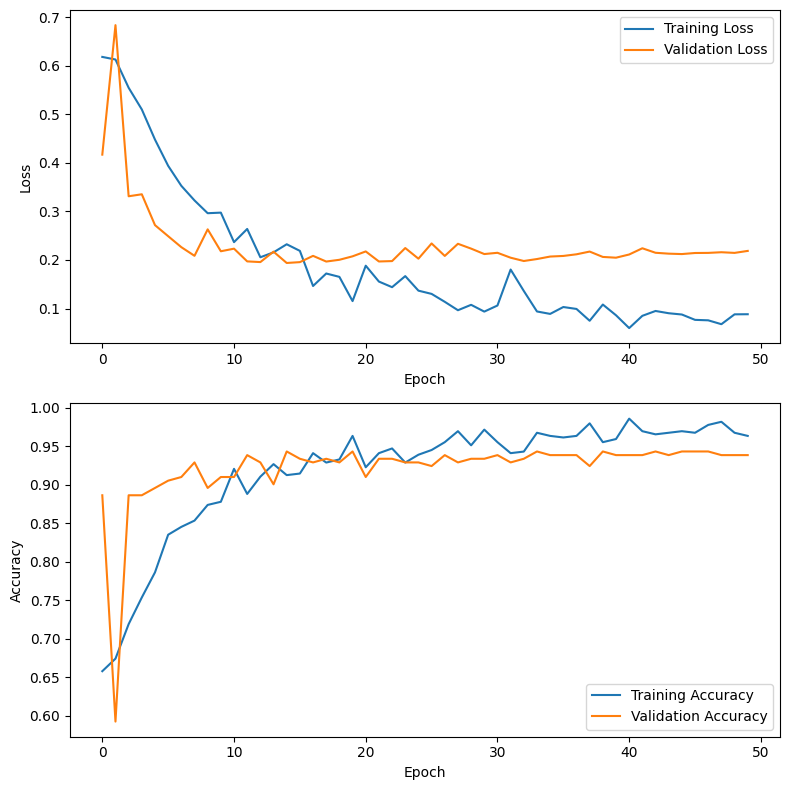

4/4 [==============================] - 9s 2s/step
0.92


In [13]:
import tensorflow as tf

optimizer = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

with tf.device("/gpu:0"):
    history = model.fit(
        x = train_datagen,
        epochs = 50,
        steps_per_epoch = 50,
        validation_data = valid_datagen,
        callbacks = [LR_sched]
    )
plot_metrics(history)

evaluate_test(model)

# RESNET50 - Base
---

In [13]:
cnn_base, model = create_model_resnet50()

cnn_base.trainable = False
model.summary(show_trainable=True)

Model: "sequential_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  N          
                                                                            
 global_max_pooling2d (Globa  (None, 2048)             0         Y          
 lMaxPooling2D)                                                             
                                                                            
 batch_normalization_1 (Batc  (None, 2048)             8192      Y          
 hNormalization)                                                            
                                                                            
 dense_1 (Dense)             (None, 2)                 4098      Y          
                                                                            
Total params: 23,600,002
Trainable params: 8,194
Non-t

Epoch 1/50
50/50 [==============================] - 12s 92ms/step - loss: 15.3572 - accuracy: 0.5845 - val_loss: 31.3838 - val_accuracy: 0.4455 - lr: 0.1000
Epoch 2/50
50/50 [==============================] - 3s 69ms/step - loss: 11.4678 - accuracy: 0.5947 - val_loss: 6.3078 - val_accuracy: 0.4787 - lr: 0.0998
Epoch 3/50
50/50 [==============================] - 3s 69ms/step - loss: 8.3693 - accuracy: 0.5682 - val_loss: 29.0968 - val_accuracy: 0.4455 - lr: 0.0994
Epoch 4/50
50/50 [==============================] - 3s 69ms/step - loss: 4.5072 - accuracy: 0.6375 - val_loss: 6.4059 - val_accuracy: 0.4408 - lr: 0.0988
Epoch 5/50
50/50 [==============================] - 3s 69ms/step - loss: 2.9938 - accuracy: 0.6069 - val_loss: 1.5423 - val_accuracy: 0.6635 - lr: 0.0980
Epoch 6/50
50/50 [==============================] - 3s 70ms/step - loss: 2.0219 - accuracy: 0.5784 - val_loss: 0.9531 - val_accuracy: 0.6209 - lr: 0.0971
Epoch 7/50
50/50 [==============================] - 3s 70ms/step - loss

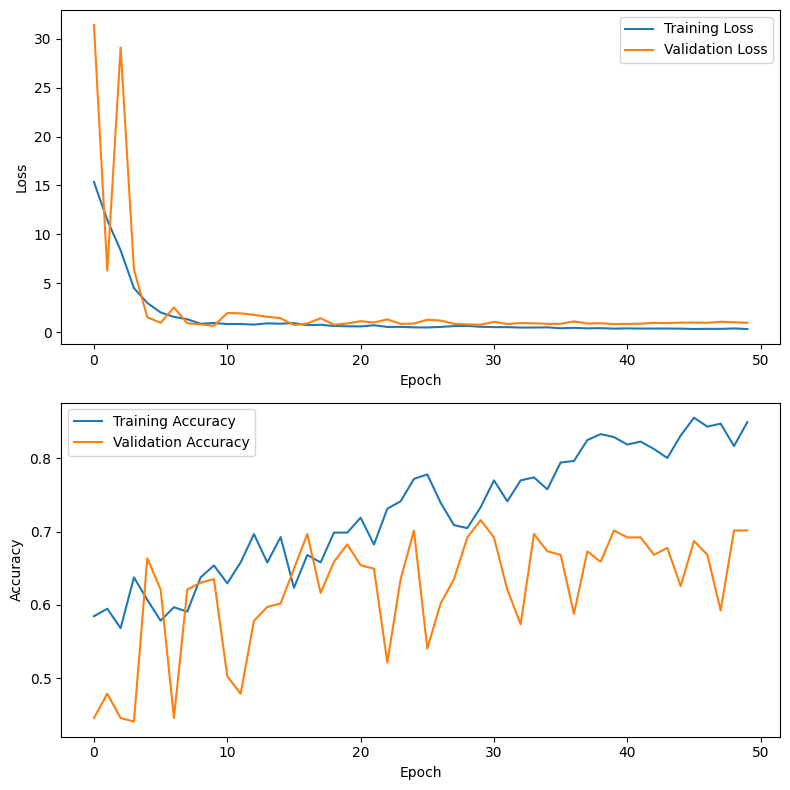

Learning rate: 0.009320735
4/4 [==============================] - 7s 1s/step
0.61


In [14]:
import tensorflow as tf

optimizer = keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

with tf.device("/gpu:0"):
    history = model.fit(
        x = X_train,
        y = y_train,
        epochs = 50,
        batch_size = 10,
        validation_data = (X_valid, y_valid),
        callbacks = [LR_sched]
    )
plot_metrics(history)

print("Learning rate:", optimizer.learning_rate.numpy())
evaluate_test(model)




In [13]:
save_weights(model, weights_path='base_model_resnet50.h5')


Saved model to disk


# RESNET50-NO AUG
---

In [17]:
cnn_base, model = create_model_resnet50()
cnn_base.trainable = False
model = load_weights(model, weights_path='base_model_resnet50.h5')

Loaded model from disk


In [18]:
cnn_base.trainable = True
set_trainable = False
for layer in cnn_base.layers:
    if layer.name == 'conv5_block3_3_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1

Epoch 1/50
50/50 [==============================] - 11s 84ms/step - loss: 1.2280 - accuracy: 0.5153 - val_loss: 267.6416 - val_accuracy: 0.5118 - lr: 0.1000
Epoch 2/50
50/50 [==============================] - 3s 63ms/step - loss: 0.8871 - accuracy: 0.5356 - val_loss: 21.0075 - val_accuracy: 0.5118 - lr: 0.0998
Epoch 3/50
50/50 [==============================] - 3s 63ms/step - loss: 0.7222 - accuracy: 0.5764 - val_loss: 3.1501 - val_accuracy: 0.5071 - lr: 0.0994
Epoch 4/50
50/50 [==============================] - 3s 62ms/step - loss: 0.6921 - accuracy: 0.5580 - val_loss: 5.7809 - val_accuracy: 0.4976 - lr: 0.0988
Epoch 5/50
50/50 [==============================] - 3s 62ms/step - loss: 0.7061 - accuracy: 0.5601 - val_loss: 1.2128 - val_accuracy: 0.5024 - lr: 0.0980
Epoch 6/50
50/50 [==============================] - 3s 62ms/step - loss: 0.6995 - accuracy: 0.5560 - val_loss: 0.7577 - val_accuracy: 0.5071 - lr: 0.0971
Epoch 7/50
50/50 [==============================] - 3s 63ms/step - loss:

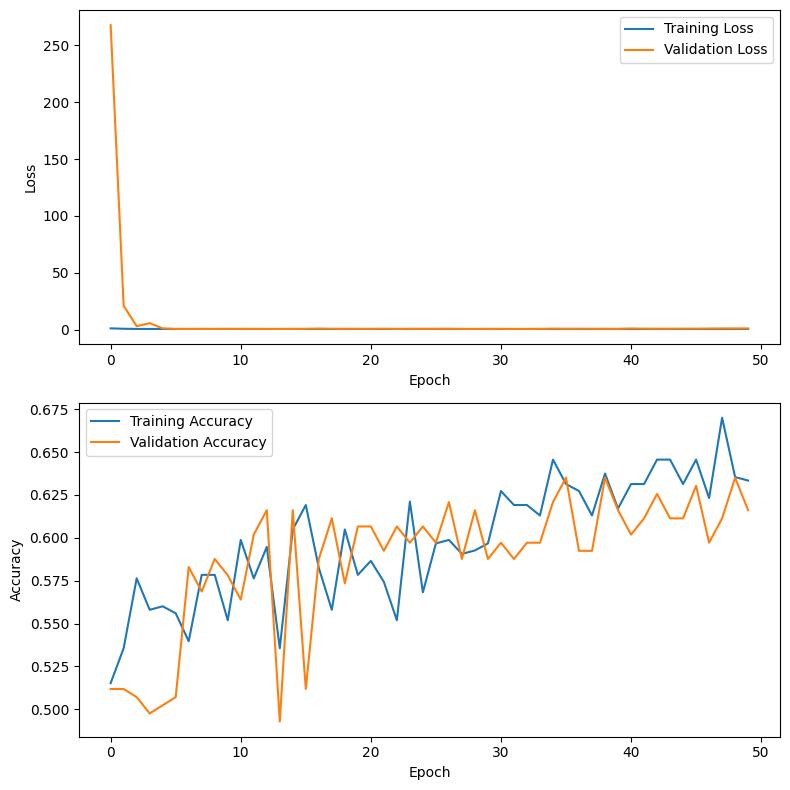

4/4 [==============================] - 7s 1s/step
0.56


In [19]:
import tensorflow as tf

optimizer = keras.optimizers.SGD(learning_rate=1e-1, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

with tf.device("/gpu:0"):
    history = model.fit(
        x = X_train,
        y = y_train,
        epochs = 50,
        batch_size = 10,
        validation_data = valid_datagen,
        callbacks = [LR_sched]
    )
plot_metrics(history)

evaluate_test(model)

# RESNET50-AUG
---

In [11]:
cnn_base, model = create_model_resnet50()
cnn_base.trainable = False
model = load_weights(model, weights_path='base_model_resnet50.h5')

# evaluate_test(model)

Loaded model from disk


In [12]:
cnn_base.trainable = True
set_trainable = False
for layer in cnn_base.layers:
    if layer.name == 'conv5_block3_3_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 2048)       8192      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                        

Epoch 1/50
10/10 [==============================] - 10s 293ms/step - loss: 1.5508 - accuracy: 0.5100 - val_loss: 1072.1686 - val_accuracy: 0.4739 - lr: 0.0500
Epoch 2/50
10/10 [==============================] - 2s 190ms/step - loss: 2.2712 - accuracy: 0.5400 - val_loss: 2192.8113 - val_accuracy: 0.5261 - lr: 0.0499
Epoch 3/50
10/10 [==============================] - 2s 183ms/step - loss: 1.9539 - accuracy: 0.5900 - val_loss: 905.0040 - val_accuracy: 0.4739 - lr: 0.0497
Epoch 4/50
10/10 [==============================] - 2s 174ms/step - loss: 1.6669 - accuracy: 0.5400 - val_loss: 128.6756 - val_accuracy: 0.5261 - lr: 0.0494
Epoch 5/50
10/10 [==============================] - 2s 172ms/step - loss: 2.3561 - accuracy: 0.4500 - val_loss: 298.8649 - val_accuracy: 0.5261 - lr: 0.0490
Epoch 6/50
10/10 [==============================] - 2s 171ms/step - loss: 1.9458 - accuracy: 0.5800 - val_loss: 69.3413 - val_accuracy: 0.4739 - lr: 0.0485
Epoch 7/50
10/10 [==============================] - 2s 1

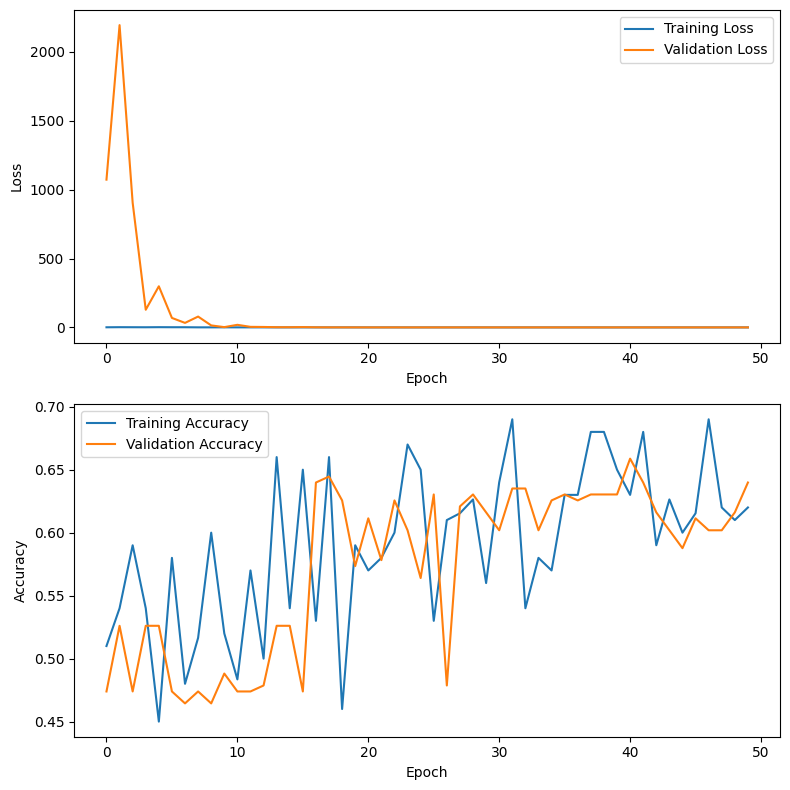

4/4 [==============================] - 9s 2s/step
0.6


In [13]:
import tensorflow as tf

optimizer = keras.optimizers.SGD(learning_rate=5e-2, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

with tf.device("/gpu:0"):
    history = model.fit(
        x = train_datagen,
        epochs = 50,
        # batch_size = 10,
        steps_per_epoch = 10,
        validation_data = valid_datagen,
        callbacks = [LR_sched]
    )
plot_metrics(history)

evaluate_test(model)

Input Layer:

Shape: (None, 224, 224, 3)
The input layer expects images with a shape of (224, 224, 3), representing RGB images with a height and width of 224 pixels.
Convolutional Blocks:

The convolutional part of VGG16 consists of five blocks, each containing multiple convolutional layers (with 3x3 filters), followed by a max pooling layer (2x2 pool size). The number of filters increases as you go deeper into the network.

- Block 1:

    - Conv1_1: (None, 224, 224, 64)

    - Conv1_2: (None, 224, 224, 64)

    - MaxPooling1: (None, 112, 112, 64)

- Block 2:

    - Conv2_1: (None, 112, 112, 128)

    - Conv2_2: (None, 112, 112, 128)

    - MaxPooling2: (None, 56, 56, 128)

- Block 3:

    - Conv3_1: (None, 56, 56, 256)

    - Conv3_2: (None, 56, 56, 256)

    - Conv3_3: (None, 56, 56, 256)

    - MaxPooling3: (None, 28, 28, 256)

- Block 4:

    - Conv4_1: (None, 28, 28, 512)

    - Conv4_2: (None, 28, 28, 512)

    - Conv4_3: (None, 28, 28, 512)

    - MaxPooling4: (None, 14, 14, 512)

- Block 5:

    - Conv5_1: (None, 14, 14, 512)

    - Conv5_2: (None, 14, 14, 512)

    - Conv5_3: (None, 14, 14, 512)

    - MaxPooling5: (None, 7, 7, 512)
